## NB Creating the arc flagging figure
@author: Max Felius
@date: 25/05/2021

In [2]:
#imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os, sys, time
import re, datetime
from scipy import spatial
from tqdm import tqdm

#import personal functions
sys.path.extend(os.path.join(os.getcwd(),'sinkhole_functions'))
from sinkhole_functions import process_arc_connections as pac
from sinkhole_functions import linear_model as lm
from sinkhole_functions import process_arc_flagging as paf

In [3]:
#loading the data
folder = ''
filename1 = 'Implemented_linear_Franciscanerstraat_sinkhole_final2.csv'
location_file = 'sinkhole_kerkrade.csv'

#load the data
data = pd.read_csv(os.path.join(folder,filename1))
location = pd.read_csv(os.path.join(folder,location_file))

# epochs_print = get_sentinel_day(data)

print(f'The number of epochs of the data is {len(list(data))-31}')

#get information from pandas df
headers = list(data)
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.pnt_lon, data.pnt_lat))
data_gdf.crs = 'epsg:4326' #wgs84
data_gdf = data_gdf.to_crs('epsg:28992') #to Amersfoort Rijksdriehoekenstelsel
location_gdf = gpd.GeoDataFrame(location, geometry=gpd.points_from_xy(location.longitude, location.latitude))
location_gdf.crs = 'epsg:4326' #wgs84
location_gdf = location_gdf.to_crs('epsg:28992') # to Amersfoort Rijksdriehoekenstelsel

#make the kdtree for quick subset creation
rdx = data['pnt_rdx'].values
rdy = data['pnt_rdy'].values
rd_data = np.concatenate((rdx.reshape(len(rdx),1),rdy.reshape(len(rdy),1)),axis=1)
tree = spatial.cKDTree(rd_data)

x0 = location_gdf.geometry.x.values[0]
y0 = location_gdf.geometry.y.values[0]

#cropping the dataset
subset = tree.query_ball_point(([x0,y0]),r=80)
data = data.iloc[subset]

#make the kdtree for quick subset creation
rdx = data['pnt_rdx'].values
rdy = data['pnt_rdy'].values
rd_data = np.concatenate((rdx.reshape(len(rdx),1),rdy.reshape(len(rdy),1)),axis=1)
tree = spatial.cKDTree(rd_data)

The number of epochs of the data is 110


In [4]:
import overpass

data_gdf2 = data_gdf#.to_crs('epsg:4326')

longs = data_gdf2.geometry.x.values
lats = data_gdf2.geometry.y.values

# bounding box coordinates
min_rdx = min(longs)
min_rdy = min(lats)
max_rdx = max(longs)
max_rdy = max(lats)

# # query overpass within OpenStreetMap
# api = overpass.API()
# map_query = overpass.MapQuery(min_lat,min_long,max_lat,max_long)
# response = api.Get(map_query)

print(min_rdx,min_rdy,max_rdx,max_rdy)

202804.91882081408 318151.55470474216 203055.1391236829 318542.34502362146


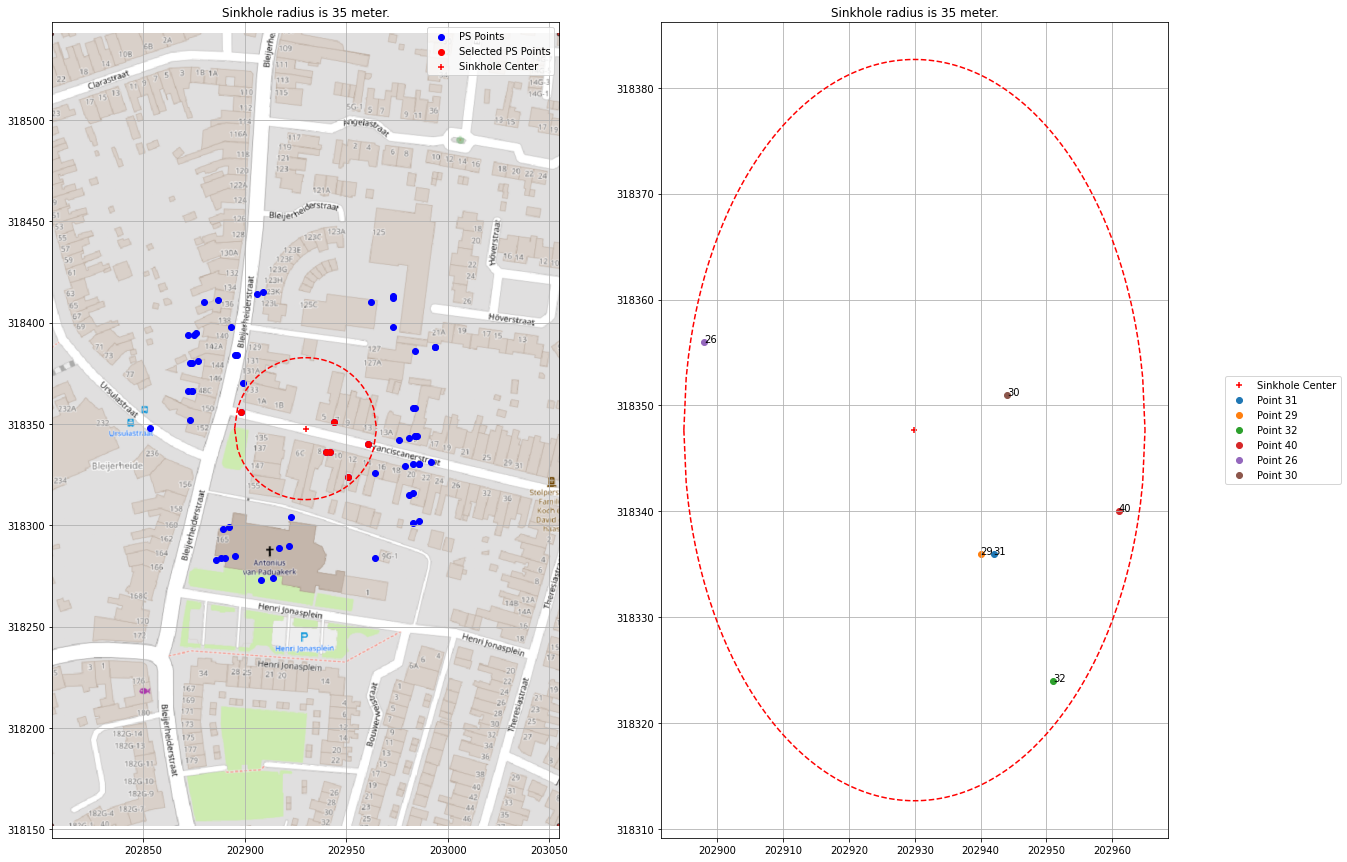

In [10]:
#load the data
data2 = pd.read_csv(os.path.join(folder,filename1))

#get information from pandas df
headers = list(data)
data_gdf2 = gpd.GeoDataFrame(data2, geometry=gpd.points_from_xy(data2.pnt_lon, data2.pnt_lat))
data_gdf2.crs = 'epsg:4326' #wgs84
data_gdf2 = data_gdf2.to_crs('epsg:28992') #to Amersfoort Rijksdriehoekenstelsel
rdx2 = data2['pnt_rdx'].values
rdy2 = data2['pnt_rdy'].values
rd_data2 = np.concatenate((rdx2.reshape(len(rdx2),1),rdy2.reshape(len(rdy2),1)),axis=1)
# tree = spatial.cKDTree(rd_data)


rdxs = data_gdf.geometry.x.values
rdys = data_gdf.geometry.y.values



R = 35

#ps points subset
subset = tree.query_ball_point([x0,y0],r=R)
                               
#placing the sinkhole 
fig, ax = plt.subplots(figsize=(20,15),nrows=1,ncols=2)

ax[0].scatter(rdx,rdy,c='b',label='PS Points')

# ax[0].scatter(xv_u,yv_u,c='g',label='Grid Points')
ax[0].scatter(rdx[subset],rdy[subset],c='r',label='Selected PS Points')

R = 35 #radius of influence of the sinkhole
x_test = np.linspace(x0-R,x0+R,50)

ax[0].scatter(x0,y0,c='r',marker='+',label='Sinkhole Center')
ax[0].plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
ax[0].plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

ax[0].set_title(f'Sinkhole radius is {R} meter.')
ax[0].legend()
ax[0].axis('equal')
ax[0].grid(True);

min_rdx = min(rdxs)
min_rdy = min(rdys)
max_rdx = max(rdxs)
max_rdy = max(rdys)
img = plt.imread('background.png')
extents = (min_rdx, max_rdx, min_rdy, max_rdy)


# ax[0].set_xlim([np.min(data['pnt_rdx'].values),np.max(data['pnt_rdx'].values)])
# ax[0].set_ylim([np.max(data['pnt_rdy'].values),np.min(data['pnt_rdy'].values)])
ax[0].imshow(img,extent=extents)

#--------------NEW SUBPLOT----------------------
x_test = np.linspace(x0-R,x0+R,200)

# ax[1].scatter(rdx[subset],rdy[subset],c='r',label='Selected PS Points')
ax[1].scatter(x0,y0,c='r',marker='+',label='Sinkhole Center')
ax[1].plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
ax[1].plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

for isubset in subset:
    label_in = data_gdf['id'].iloc[isubset]
    ax[1].scatter(rdx[isubset],rdy[isubset],label=f'Point {isubset}')
    ax[1].text(rdx[isubset],rdy[isubset],s=f'{isubset}')
    
# ax[1].invert_yaxis()
ax[1].set_title(f'Sinkhole radius is {R} meter.')
ax[1].legend(bbox_to_anchor=(1.35, 0.5),loc='center right')
ax[1].grid(True);
ax[1].ticklabel_format(useOffset=False);

# Processing Arc connections

In [6]:
processed_data_object = pac.process_arc_connections(data)
processed_data_object.process_arc_connections();

Processing Arc Connections...:   0%|          | 0/110 [00:00<?, ?it/s]

Creating tuple list.


Processing Arc Connections...: 100%|██████████| 110/110 [00:07<00:00, 15.50it/s]

Finished processing arc connections.


# Processing Connections - Fixed set of epochs

In [18]:
epochs_used = 60
flagging_dict = {}

epochs_selected = processed_data_object.epoch_headers[:epochs_used]

#linear model
start = time.time()
print('Computing the linear model per arc')
model = lm.linear_model()
a, b, sigma_ehat = model.linear_model(epochs_selected,processed_data_object.processed_data)
print('Finsihed computing the linear model per arc. Time elapsed: {:.02f} seconds.'.format(time.time()-start))

for i in tqdm(range(len(processed_data_object.epoch_headers)-epochs_used),'Flagging in Process...'):
#     epochs_selected = processed_data_object.epoch_headers[i:i+epochs_used]
    old_epoch = processed_data_object.epoch_headers[epochs_used+i-1]
    new_epoch = processed_data_object.epoch_headers[epochs_used+i]
    
    #create the flagging object
    flagging_object = paf.process_arc_flagging()
    
    epochs_days = epochs_selected + [new_epoch]
    
    delta_days_array,start_date = flagging_object.get_delta_day(epochs_days) 
    
    #saving variable
    flagging_dict[new_epoch] = []
    
    #go over all the rows
    for ii in range(len(a)):
        y = processed_data_object.processed_data[new_epoch].iloc[ii]
        flag = flagging_object.flagging(a[ii],b[ii],y,sigma_ehat[ii],delta_days_array[-1])
        
        if i != 0:
            if flagging_dict[old_epoch][ii] != 0 and flag == 1:
                if flagging_dict[old_epoch][ii] == 4:
                    flag = 4
                else:
                    flag = flagging_dict[old_epoch][ii] + 1
#                 pass
        
        #save flag
        flagging_dict[new_epoch].append(flag)

flagged_data_fixed = pd.DataFrame.from_dict(flagging_dict)

Computing the linear model per arc


Flagging in Process...:   4%|▍         | 2/50 [00:00<00:04, 11.78it/s]

Finsihed computing the linear model per arc. Time elapsed: 3.88 seconds.


Flagging in Process...: 100%|██████████| 50/50 [00:01<00:00, 26.31it/s]


# Figure: Number of Connections pre-processing

In [19]:
flagged_data = flagged_data_fixed

n = len(data) #number of points
tuple_list = processed_data_object.create_tuple_pairs(n)

point_dt = {}

#create column for point id
point_dt['Point ID'] = [x for x in range(n)]
point_dt['ID'] = list(data['Unnamed: 0'].values)

#create zero matrix
for epoch in list(flagged_data):
    point_dt[epoch] = np.zeros((n))

point_matrix = pd.DataFrame.from_dict(point_dt)

for idx in tqdm(range(len(tuple_list)),):
    tuple_id = tuple_list[idx]
    for epoch in list(flagged_data):
        id1 = tuple_id[0]
        id2 = tuple_id[1]

        point_matrix[epoch].iloc[id1] += flagged_data[epoch].iloc[idx]
        point_matrix[epoch].iloc[id2] += flagged_data[epoch].iloc[idx]

  0%|          | 2/1830 [00:00<01:51, 16.41it/s]

Creating tuple list.


100%|██████████| 1830/1830 [00:48<00:00, 37.73it/s]


# Combine both arc flagging with number of connection

## Todo
- ~implement osm in arc connection figure~
- ~implement same point colors in both figures~
- ~implement background gradient in number of connections figure corresponding to the risk level~

In [9]:
jet = plt.get_cmap('inferno_r').colors
range_idx = 15
# idx = np.arange(0,256,int(256/range_idx))
idx = np.array([0,10,255])
jet_rescale = np.array(jet)[idx]

print(jet_rescale)

[[9.88362e-01 9.98364e-01 6.44924e-01]
 [9.47937e-01 9.49318e-01 4.91426e-01]
 [1.46200e-03 4.66000e-04 1.38660e-02]]


In [44]:
# DO Something about the colormap of the lines
flagged_data = flagged_data_fixed

save_folder = 'figures_fixed_fringe_combined_new2'

if not os.path.exists(save_folder):
    os.mkdir(save_folder)

df_rd = processed_data_object.processed_data[['rdx','rdy']]
epoch_list = list(flagged_data)

#set maximum iteration
epoch_processed = epoch_list
epochs_total = np.array(list(map(lambda e: datetime.datetime.strptime(e,'d_%Y%m%d'),list(epoch_processed))))

df_rd = processed_data_object.processed_data[['rdx','rdy']]

#colors for points
viridis = plt.get_cmap('viridis_r').colors
idx = np.arange(0,len(data),1)
viridis_rescale = np.array(viridis)[idx]

#color for arcs
jet = plt.get_cmap('inferno_r').colors
range_idx = 3
# idx = np.arange(0,256,int(256/range_idx))
idx = np.array([0,128,255])
jet_rescale = np.array(jet)[idx]

#import background image
rdxs = data_gdf.geometry.x.values
rdys = data_gdf.geometry.y.values

# bounding box coordinates
min_rdx = min(rdxs)
min_rdy = min(rdys)
max_rdx = max(rdxs)
max_rdy = max(rdys)
img = plt.imread('background.png')
extents = (min_rdx, max_rdx, max_rdy, min_rdy)

# for ii in tqdm(range(len(epoch_processed)),'Making the plots...'):
for ii in tqdm(range(0,len(epoch_processed)),'Making the plots...'):
    #make fig
    fig, ax = plt.subplots(ncols=2,figsize=(22,10))
    fig.subplots_adjust(wspace=0.3)
    plt.rcParams.update({'font.size': 14})
    
    #select current epoch
    epoch_selected = epoch_processed[ii]
#--------------SUBPLOT 1 - arc flagging -------------------------------
#     ax[0].scatter(data['pnt_rdx'].values,data['pnt_rdy'].values,c='r',label='Measurement Locations')
    ax[0].scatter(data['pnt_rdx'].values,data['pnt_rdy'].values,color=viridis_rescale,label='Measurement Locations')
    
    for i in range(len(df_rd)):
        if i == 0:
            for iii in range(len(data['pnt_rdx'].values)):
                ax[0].text(data['pnt_rdx'].values[iii],data['pnt_rdy'].values[iii], list(data.index)[iii], color="black", fontsize=12)

        if flagged_data[epoch_selected].iloc[i] > 1:
            color_line = flagged_data[epoch_selected].iloc[i]-2
            if color_line >= range_idx:
                color_line = range_idx-1
                ax[0].plot(df_rd['rdx'].iloc[i],df_rd['rdy'].iloc[i],color=jet_rescale[color_line])
            else:
                ax[0].plot(df_rd['rdx'].iloc[i],df_rd['rdy'].iloc[i],color=jet_rescale[color_line])

        # figure settings and labels
    ax[0].grid(True)
    ax[0].imshow(img,extent=extents)
    
    epoch_selected_datetime = datetime.datetime.strptime(epoch_selected,'d_%Y%m%d')
    
    ax[0].set_title('Flagged Arcs. Current Epoch: {}'.format(epoch_selected_datetime.strftime("%d-%m-%Y")))
    ax[0].set_xlabel('Distance East [m]')
    ax[0].set_ylabel('Distance South [m]')
#     ax[0].legend()

    # colorbar
    h = ax[0].scatter([],[],c=[] ,vmin=0, vmax=range_idx,cmap='inferno')
    cbar = plt.colorbar(h,ax=ax[0],ticks=[range_idx,0.5*range_idx,0])
    cbar.ax.invert_yaxis()
    cbar.ax.set_yticklabels(['Low flag count', 'Medium flag count', 'High flag count']);
    
    ax[0].axis('equal')
    
    #set limits
    ax[0].set_xlim([np.min(data['pnt_rdx'].values),np.max(data['pnt_rdx'].values)])
    ax[0].set_ylim([np.max(data['pnt_rdy'].values),np.min(data['pnt_rdy'].values)])

    
    #save the figure
#     

#--------------SUBPLOT 2 - Number of Connections ----------------------  
    test = 1
#     epochs_sel = epoch_processed[:ii+10]
    epochs_sel = np.array(list(map(lambda e: datetime.datetime.strptime(e,'d_%Y%m%d'),list(epoch_processed[:ii+test]))))
    epochs_string = epoch_processed[ii]
    
    x_array = np.arange(0,len(data),1)
    
#     for i in range(len(point_matrix)):
#         if point_matrix['ID'].iloc[i] in subset_points:
#             label_in = point_matrix['ID'].iloc[i]
#             ax[1].scatter(epochs_sel,point_matrix[epochs_string].iloc[i],s=80,label=f'Point: {label_in}')
#             ax[1].scatter(epochs_sel,point_matrix[epochs_string].iloc[i],c='k',s=5)
#         else:
#     print(x_array,list(epoch_processed))
    ax[1].bar(x_array,point_matrix[epochs_string].values.T,color=viridis_rescale)

#     ax[1].legend();
    for i in range(len(point_matrix)):
        if point_matrix[epochs_string].iloc[i] > 25:
            ax[1].text(x_array[i],point_matrix[epochs_string].iloc[i], list(data.index)[i], color="black", fontsize=12)
    
    ax[1].set_title('Total Flagged Value per Observation.')
    ax[1].set_xticks(np.arange(len(list(data.index))), list(data.index))
#     ax[1].set_xticklabels(list(data.index))
    ax[1].set_xticklabels(['']*len(data))
    ax[1].set_xlabel('Point ID')
    ax[1].set_ylabel('Total Flagged Value')
    ax[1].set_ylim([0,250])
#     ax[1].set_xlim([epochs_total[0],epochs_total[-1]])
    
    plotlim = plt.xlim() + plt.ylim() 
#     ax[1].imshow([[0,0],[1,1]], cmap=plt.get_cmap('inferno'), interpolation='bicubic', extent=plotlim,alpha=0.6,aspect='auto')
    ax[1].grid(True);
    

    if ii in select_image_list:
        save_selected_image1()
        save_selected_image2()
#         break
    
#     break
    plt.savefig(os.path.join(save_folder,'{:02d}_{}.png'.format(ii,epoch_selected)))
    plt.close('all')
#     

Making the plots...:   0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-44-6f20a4780813>:118: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks(np.arange(len(list(data.index))), list(data.index))
<ipython-input-44-6f20a4780813>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['']*len(data))
<ipython-input-43-e4a4b27d300a>:70: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(np.arange(len(list(data.index))), list(data.index))
<ipython-input-43-e4a4b27d300a>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']*len(data))
Making the plots...: 100%|██████████| 50/50 [01:27<00:0

In [43]:
select_image_list = [0,23,33,39,49]

def save_selected_image1():
    fig, ax = plt.subplots(figsize=(11,10))
    
    ax.scatter(data['pnt_rdx'].values,data['pnt_rdy'].values,color=viridis_rescale,label='Measurement Locations')
    
    for i in range(len(df_rd)):
        if i == 0:
            for iii in range(len(data['pnt_rdx'].values)):
                ax.text(data['pnt_rdx'].values[iii],data['pnt_rdy'].values[iii], list(data.index)[iii], color="black", fontsize=12)

        if flagged_data[epoch_selected].iloc[i] > 1:
            color_line = flagged_data[epoch_selected].iloc[i]-2
            if color_line >= range_idx:
                color_line = range_idx-1
                ax.plot(df_rd['rdx'].iloc[i],df_rd['rdy'].iloc[i],color=jet_rescale[color_line])
            else:
                ax.plot(df_rd['rdx'].iloc[i],df_rd['rdy'].iloc[i],color=jet_rescale[color_line])

        # figure settings and labels
    ax.grid(True)
    ax.imshow(img,extent=extents)
    
    epoch_selected_datetime = datetime.datetime.strptime(epoch_selected,'d_%Y%m%d')
    
    ax.set_title('Flagged Arcs. Current Epoch: {}'.format(epoch_selected_datetime.strftime("%d-%m-%Y")))
    ax.set_xlabel('Distance East [m]')
    ax.set_ylabel('Distance South [m]')
#     ax[0].legend()

    # colorbar
    h = ax.scatter([],[],c=[] ,vmin=0, vmax=range_idx,cmap='inferno')
    cbar = plt.colorbar(h,ax=ax,ticks=[range_idx,0.5*range_idx,0])
    cbar.ax.invert_yaxis()
    cbar.ax.set_yticklabels(['Low flag count', 'Medium flag count', 'High flag count']);
    
    ax.axis('equal')
    
    #set limits
    ax.set_xlim([np.min(data['pnt_rdx'].values),np.max(data['pnt_rdx'].values)])
    ax.set_ylim([np.max(data['pnt_rdy'].values),np.min(data['pnt_rdy'].values)])
    
    plt.savefig(os.path.join(save_folder,'{:02d}_{}_flagged_arcs.png'.format(ii,epoch_selected)))
    
def save_selected_image2():
    fig, ax = plt.subplots(figsize=(11,10))
    test = 1
#     epochs_sel = epoch_processed[:ii+10]
    epochs_sel = np.array(list(map(lambda e: datetime.datetime.strptime(e,'d_%Y%m%d'),list(epoch_processed[:ii+test]))))
    epochs_string = epoch_processed[ii]
    
    x_array = np.arange(0,len(data),1)
    
#     for i in range(len(point_matrix)):
#         if point_matrix['ID'].iloc[i] in subset_points:
#             label_in = point_matrix['ID'].iloc[i]
#             ax[1].scatter(epochs_sel,point_matrix[epochs_string].iloc[i],s=80,label=f'Point: {label_in}')
#             ax[1].scatter(epochs_sel,point_matrix[epochs_string].iloc[i],c='k',s=5)
#         else:
#     print(x_array,list(epoch_processed))
    ax.bar(x_array,point_matrix[epochs_string].values.T,color=viridis_rescale)

#     ax[1].legend();
    for i in range(len(point_matrix)):
        if point_matrix[epochs_string].iloc[i] > 25:
            ax.text(x_array[i],point_matrix[epochs_string].iloc[i], list(data.index)[i], color="black", fontsize=12)
    
    ax.set_title('Total Flagged Value per Observation. Current epoch: {}.'.format(epoch_selected_datetime.strftime("%d-%m-%Y")))
    ax.set_xticks(np.arange(len(list(data.index))), list(data.index))
#     ax[1].set_xticklabels(list(data.index))
    ax.set_xticklabels(['']*len(data))
    ax.set_xlabel('Point ID')
    ax.set_ylabel('Total Flagged Value')
    ax.set_ylim([0,250])
#     ax[1].set_xlim([epochs_total[0],epochs_total[-1]])
    
    plotlim = plt.xlim() + plt.ylim() 
#     ax[1].imshow([[0,0],[1,1]], cmap=plt.get_cmap('inferno'), interpolation='bicubic', extent=plotlim,alpha=0.6,aspect='auto')
    ax.grid(True);
    
    plt.savefig(os.path.join(save_folder,'{:02d}_{}_bar_plot.png'.format(ii,epoch_selected)));

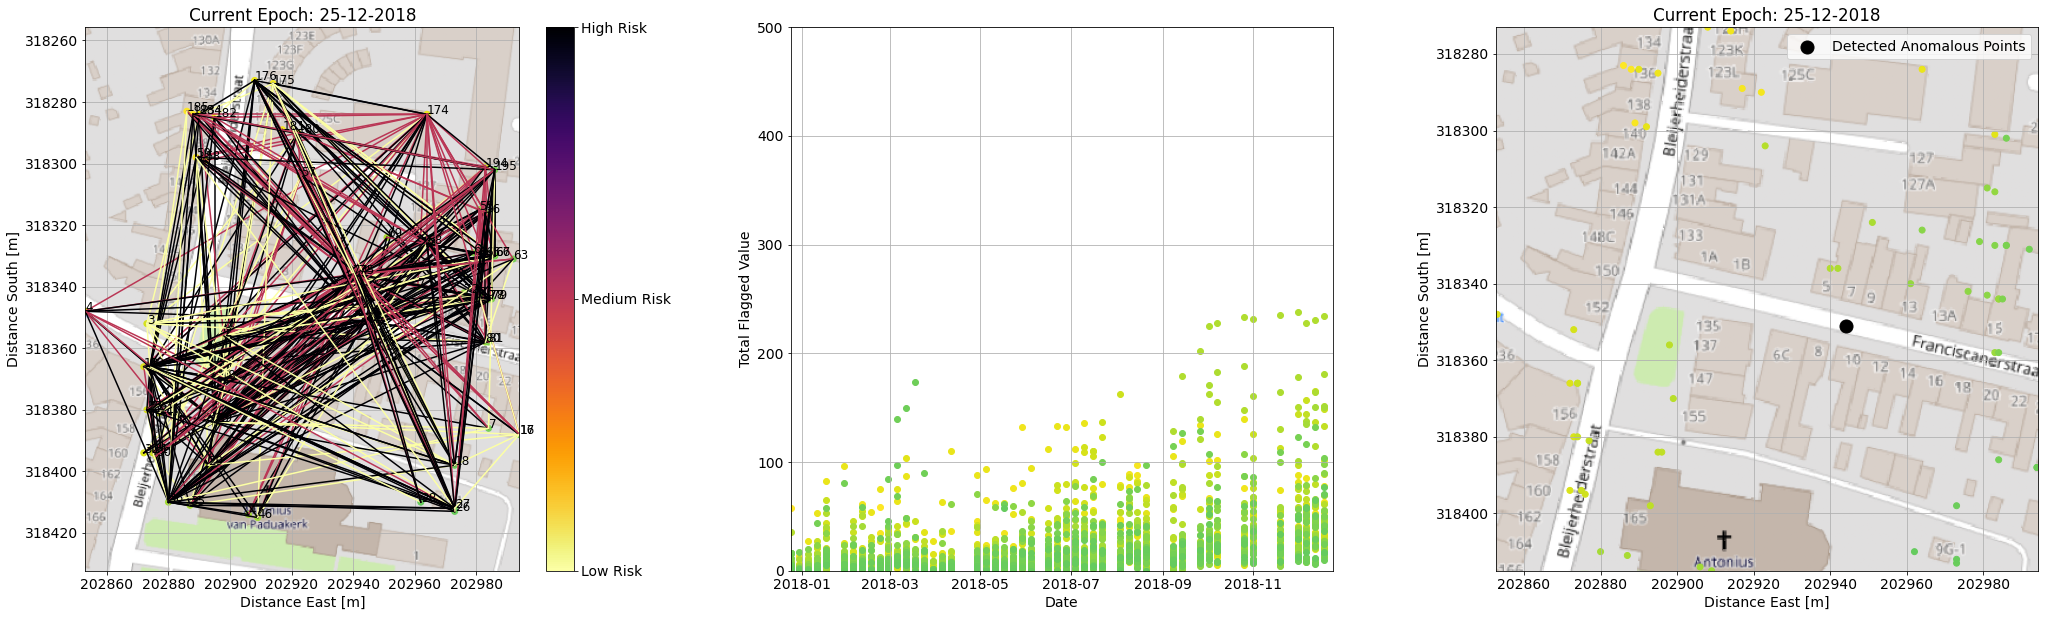

In [11]:
# for ii in tqdm(range(len(epoch_processed)),'Making the plots...'):
ii = len(epoch_processed)-1

#make fig
fig, ax = plt.subplots(ncols=3,figsize=(35,10))
fig.subplots_adjust(wspace=0.3)
plt.rcParams.update({'font.size': 14})

#select current epoch
epoch_selected = epoch_processed[ii]
#--------------SUBPLOT 1 - arc flagging -------------------------------
#     ax[0].scatter(data['pnt_rdx'].values,data['pnt_rdy'].values,c='r',label='Measurement Locations')
ax[0].scatter(data['pnt_rdx'].values,data['pnt_rdy'].values,color=viridis_rescale,label='Measurement Locations')

for i in range(len(df_rd)):
    if i == 0:
        for iii in range(len(data['pnt_rdx'].values)):
            ax[0].text(data['pnt_rdx'].values[iii],data['pnt_rdy'].values[iii], list(data.index)[iii], color="black", fontsize=12)

    if flagged_data[epoch_selected].iloc[i] > 1:
        color_line = flagged_data[epoch_selected].iloc[i]-2
        if color_line >= range_idx:
            color_line = range_idx-1
            ax[0].plot(df_rd['rdx'].iloc[i],df_rd['rdy'].iloc[i],color=jet_rescale[color_line])
        else:
            ax[0].plot(df_rd['rdx'].iloc[i],df_rd['rdy'].iloc[i],color=jet_rescale[color_line])

    # figure settings and labels
ax[0].grid(True)
ax[0].imshow(img,extent=extents)

epoch_selected_datetime = datetime.datetime.strptime(epoch_selected,'d_%Y%m%d')

ax[0].set_title('Current Epoch: {}'.format(epoch_selected_datetime.strftime("%d-%m-%Y")))
ax[0].set_xlabel('Distance East [m]')
ax[0].set_ylabel('Distance South [m]')
#     ax[0].legend()

# colorbar
h = ax[0].scatter([],[],c=[] ,vmin=0, vmax=range_idx,cmap='inferno')
cbar = plt.colorbar(h,ax=ax[0],ticks=[range_idx,0.5*range_idx,0])
cbar.ax.invert_yaxis()
cbar.ax.set_yticklabels(['Low Risk', 'Medium Risk', 'High Risk']);

ax[0].axis('equal')

#set limits
ax[0].set_xlim([np.min(data['pnt_rdx'].values),np.max(data['pnt_rdx'].values)])
ax[0].set_ylim([np.max(data['pnt_rdy'].values),np.min(data['pnt_rdy'].values)])

#save the figure
#     

#--------------SUBPLOT 2 - Number of Connections ----------------------  
test = 0
#     epochs_sel = epoch_processed[:ii+10]
epochs_sel = np.array(list(map(lambda e: datetime.datetime.strptime(e,'d_%Y%m%d'),list(epoch_processed[:ii+test]))))
epochs_string = list(epoch_processed[:ii+test])

for i in range(len(point_matrix)):
#         if point_matrix['ID'].iloc[i] in subset_points:
#             label_in = point_matrix['ID'].iloc[i]
#             ax[1].scatter(epochs_sel,point_matrix[epochs_string].iloc[i],s=80,label=f'Point: {label_in}')
#             ax[1].scatter(epochs_sel,point_matrix[epochs_string].iloc[i],c='k',s=5)
#         else:
    ax[1].scatter(epochs_sel,point_matrix[epochs_string].iloc[i],color=viridis_rescale[i])

#     ax[1].legend();

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Total Flagged Value')
ax[1].set_ylim([0,500])
ax[1].set_xlim([epochs_total[0],epochs_total[-1]])

plotlim = plt.xlim() + plt.ylim() 
ax[1].imshow([[0,0],[1,1]], cmap=plt.get_cmap('inferno'), interpolation='bicubic', extent=plotlim,alpha=0.6,aspect='auto')
ax[1].grid(True);

#     break
#     plt.savefig(os.path.join(save_folder,'{:02d}_{}.png'.format(ii,epoch_selected)))
#     plt.close('all')

#--------------SUBPLOT 3 - Number of Connections ----------------------  
ax[2].scatter(data['pnt_rdx'].values,data['pnt_rdy'].values,color=viridis_rescale)#,label='Measurement Locations')

#mark highly flagged points
risk_threshold = 200
ax[2].scatter(data['pnt_rdx'].values[point_matrix[epochs_string[-1]]>risk_threshold],data['pnt_rdy'].values[point_matrix[epochs_string[-1]]>risk_threshold],c='k',s=170,label='Detected Anomalous Points')

ax[2].grid(True)
ax[2].imshow(img,extent=extents)

epoch_selected_datetime = datetime.datetime.strptime(epoch_selected,'d_%Y%m%d')

ax[2].set_title('Current Epoch: {}'.format(epoch_selected_datetime.strftime("%d-%m-%Y")))
ax[2].set_xlabel('Distance East [m]')
ax[2].set_ylabel('Distance South [m]')


ax[2].axis('equal')

#set limits
ax[2].set_xlim([np.min(data['pnt_rdx'].values),np.max(data['pnt_rdx'].values)])
ax[2].set_ylim([np.max(data['pnt_rdy'].values),np.min(data['pnt_rdy'].values)])

ax[2].legend()
plt.savefig(os.path.join(save_folder,'Final_Image.png'))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


NameError: name 'mplt' is not defined

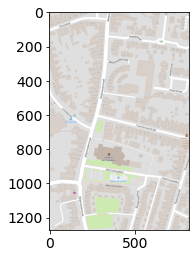

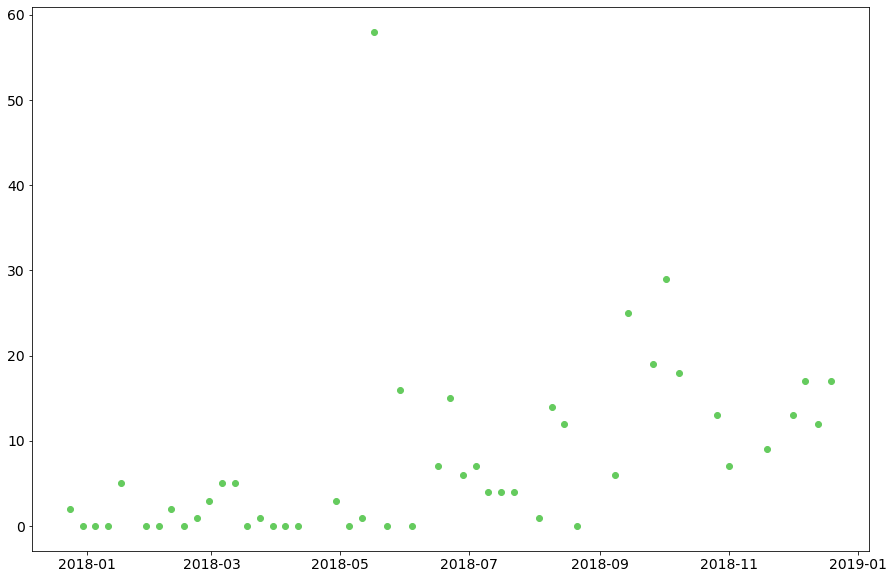

In [12]:
img = plt.imread('background.png')

plt.imshow(img)

fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(epochs_sel,point_matrix[epochs_string].iloc[i],c=viridis_rescale[i])
# mplt.plot([1,2,3],[1,2,1])  
plotlim = plt.xlim() + plt.ylim()  

ax.imshow([[0,0],[1,1]], cmap=mplt.get_cmap('inferno'), interpolation='bicubic', extent=plotlim)  
# mplt.draw()  

In [ ]:
import cv2
import os

image_folder = 'figures_fixed_fringe_combined3'
video_name = 'video.avi'

folder_list = sorted(os.listdir(image_folder))

images = [img for img in folder_list if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
import ffmpeg
(
    ffmpeg
    .input('figures_fixed_fringe_combined3/*.png', pattern_type='glob', framerate=1)
    .output('movie.mp4')
    .run()
)

In [21]:
import imageio

images = []

image_folder = save_folder

files = sorted(os.listdir(image_folder))

for file_name in files:
#     print(file_name)
    if file_name.endswith('.png'):
        file_path = os.path.join(image_folder,file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave(os.path.join(image_folder,'arc_animation.gif'),images,fps=2)

print('Done')

Done


In [22]:
import beepy
beepy.beep('coin')